# Jensen vs Larsen Wake Model Comparison


In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from src.turbine import Turbine
from src.wake_model import velocity_deficit, is_in_wake


In [2]:
# Load turbine specs
data_path = os.path.join(project_root, "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]

# Spacing: 5D
spacing = 5 * D

turbines = []
for i in range(3):
    for j in range(3):
        x = i * spacing
        y = j * spacing
        turbines.append(Turbine(x, y, D, C_T, P_rated))

turbines


In [3]:
def larsen_velocity_deficit(x, U_inf, C_T, D, k):
    """
    Larsen wake model velocity deficit fraction.
    """
    if x <= 0:
        return 0.0

    term1 = (C_T / 8)**(1/3)
    term2 = (D / (D + 2*k*x))**(2/3)
    return term1 * term2


In [4]:
def U_eff_jensen(t, turbines, U_inf, k):
    deficits = []
    for u in turbines:
        if u.x >= t.x:
            continue
        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            dU = velocity_deficit(dx, U_inf, u.C_T, u.R, k) * U_inf
            deficits.append(dU)
    if not deficits:
        return U_inf
    return max(U_inf - np.sqrt(np.sum(np.array(deficits)**2)), 0.0)


def U_eff_larsen(t, turbines, U_inf, k):
    deficits = []
    for u in turbines:
        if u.x >= t.x:
            continue
        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            dU = larsen_velocity_deficit(dx, U_inf, u.C_T, u.D, k) * U_inf
            deficits.append(dU)
    if not deficits:
        return U_inf
    return max(U_inf - np.sqrt(np.sum(np.array(deficits)**2)), 0.0)


In [5]:
U_inf = 8.0
k = 0.04

power_jensen = []
power_larsen = []

for t in turbines:
    Uj = U_eff_jensen(t, turbines, U_inf, k)
    Ul = U_eff_larsen(t, turbines, U_inf, k)

    Pj = min(P_rated, P_rated * (Uj / U_inf)**3)
    Pl = min(P_rated, P_rated * (Ul / U_inf)**3)

    power_jensen.append(Pj)
    power_larsen.append(Pl)

power_jensen, power_larsen


([3000,
  3000,
  3000,
  np.float64(1110.2815105492318),
  np.float64(1110.2815105492318),
  np.float64(1110.2815105492318),
  np.float64(903.8092140899793),
  np.float64(903.8092140899793),
  np.float64(903.8092140899793)],
 [3000,
  3000,
  3000,
  np.float64(746.9576436050378),
  np.float64(746.9576436050378),
  np.float64(746.9576436050378),
  np.float64(407.9789638101046),
  np.float64(407.9789638101046),
  np.float64(407.9789638101046)])

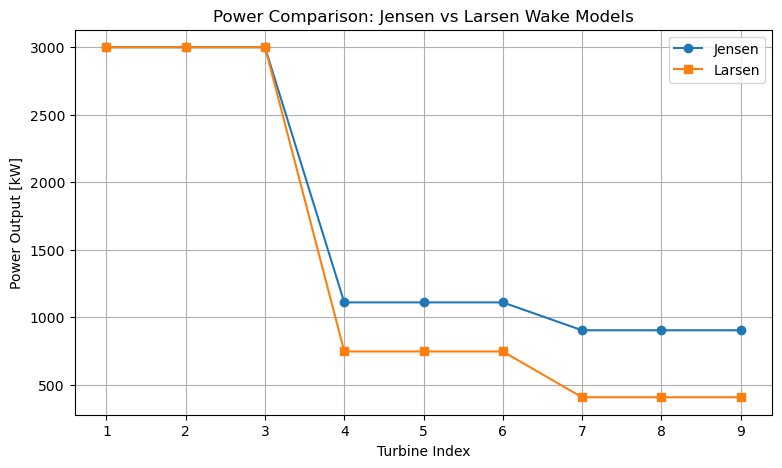

In [6]:
turbine_ids = np.arange(1, 10)

plt.figure(figsize=(9,5))
plt.plot(turbine_ids, power_jensen, marker="o", label="Jensen")
plt.plot(turbine_ids, power_larsen, marker="s", label="Larsen")

plt.xlabel("Turbine Index")
plt.ylabel("Power Output [kW]")
plt.title("Power Comparison: Jensen vs Larsen Wake Models")
plt.grid(True)
plt.legend()

results_dir = os.path.join(project_root, "results")
os.makedirs(results_dir, exist_ok=True)

plt.savefig(os.path.join(results_dir, "power_comparison_jensen_larsen.png"),
            dpi=300, bbox_inches="tight")
plt.show()


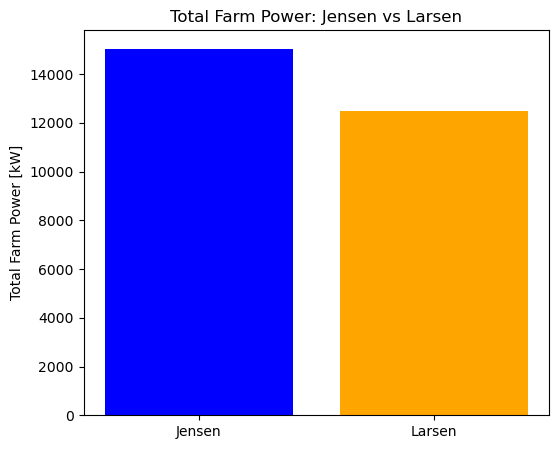

(np.float64(15042.272173917632), np.float64(12464.809822245426))

In [7]:
total_jensen = sum(power_jensen)
total_larsen = sum(power_larsen)

plt.figure(figsize=(6,5))
plt.bar(["Jensen", "Larsen"], [total_jensen, total_larsen], color=["blue", "orange"])

plt.ylabel("Total Farm Power [kW]")
plt.title("Total Farm Power: Jensen vs Larsen")

plt.savefig(os.path.join(results_dir, "total_power_jensen_vs_larsen.png"),
            dpi=300, bbox_inches="tight")
plt.show()

total_jensen, total_larsen
